# 深度学习模型
特征：
1. 滑动窗口采样
设置windows size，采样前k个step预测下一个

2. 滑动窗口平均采样

模型：
1. MLP
2. CNN
3. LSTM
4. RCNN
5. RWKV

todo：
1. 加入额外特征embedding

In [1]:
import pandas as pd
import numpy as np
import random
import pickle
import math
import os
import scipy.io
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
from datetime import datetime
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
from dataclasses import dataclass

# 1 读取处理后数据

字典数据：
```
{
    'tid':[
        [cycle_count],
        [battery_life]
    ]
}
```

DataFrame数据：
```
columns = [tid,cycle_count,life]
```

In [3]:
bmap = pickle.load(open("../data/processed/nasa-li-battery_dict_240906.pkl",'rb'))

In [4]:
# ddf = pd.read_pickle('../data/processed/nasa-li-battery_df_240906.pkl')

# 2 特征采样和评价指标

## 2.1 特征采样

In [5]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8, train_ratio=0.):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse
    

def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re

## 2.2 训练和评价

In [6]:
from tqdm import tqdm

### 绘图函数

In [7]:
def plot(name,
         real_data, 
         pred_data):
    fig, ax = plt.subplots(1, figsize=(12, 8))

    plot_range = [i for i in range(len(real_data))]
    
    ax.plot(plot_range, real_data, 'b.', label=name)
    ax.plot(plot_range, pred_data, 'r.', label='Prediction')
    plt.plot([-1,170],[2*0.7, 2*0.7], c='black', lw=1, ls='--')  # 临界点直线
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 24°C')
    plt.legend()

# 3 RNN

RNN取最后一个step接linear输出。

后续可考虑LSTM和attention。

In [8]:
from typing import List,Dict,Tuple

In [9]:
from collections import OrderedDict

In [10]:
import torch

In [11]:
class NASALiBatteryDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 fpath:str,
                ):
        
        x_lst,y_lst = [],[]
        self.data_dict = pickle.load(open(fpath,'rb'))
        for name in self.data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(self.data_dict, name, window_size)
            real_train_y = np.expand_dims(train_y[:,-1],-1)
            x_lst.append(train_x)
            y_lst.append(real_train_y)
        self.train_x = np.vstack(x_lst)
        self.train_y = np.vstack(y_lst)
        
    def __len__(self):
        return self.train_x.shape[0]
        
    def __getitem__(self, indices):
        
        return np.take(self.train_x,axis=0,indices=indices), np.take(self.train_y,axis=0,indices=indices)

In [12]:
class BaseModel(torch.nn.Module):

    def __init__(self, 
                 prefix_length:int=1,
                 device:str='cpu'):
        super(BaseModel, self).__init__()
        
        self.prefix_length = prefix_length
        self.device = device
    def __post_init__(self):
        self.double()
        
    def decode(self,
               input_x:np.array,
               max_length:int):
        '''
        input_x: List(prefix_length, )
        max_length: target decode length
        '''
        if not self.prefix_length != len(input_x):
            assert(f'Error input sequence must be prefix_length shape:{self.prefix_length}')

        test_x = input_x
        
        # decode to target length
        for i in range(max_length+1):
            online_x = np.array(test_x[-self.prefix_length:])
            online_x = torch.tensor(online_x).reshape((1,online_x.shape[0])).double().to(self.device)
            test_x += self.forward(online_x).flatten().detach().numpy().tolist() #测试值加入原来序列用来继续预测下一个点

        # list
        return test_x
        
    def forward(self, 
                x:torch.Tensor):
        '''
        x: (prefix_length, )
        '''
        pass

In [13]:
seq_length = 32
qk_dim = 27
v_dim = 16
feature_size = 15

In [14]:
test = torch.rand((64,seq_length,feature_size))

In [15]:
class RNNATTModel(BaseModel):

    def __init__(self,
                 feature_size:int,
                 qk_dim:int,
                 v_dim:int,
                 model_type:str='rnn',
                 num_layers:int=1,
                 prefix_length:int=1,
                 device:str='cpu'):
        super(RNNATTModel, self).__init__(
            prefix_length=prefix_length,
               device=device
        )
        self.feature_size = feature_size
        self.qk_dim = qk_dim
        self.v_dim = v_dim
        # 只有一个channel 所以默认input_size和hidden_size为1，没啥需要设置的参数
        self.RNNLayer = torch.nn.RNN(input_size=1,
                                                hidden_size=self.prefix_length,
                                                num_layers=num_layers,
                                                batch_first=True,
                                                dropout=0.5,
                                                bidirectional=False)
        if model_type == 'gru':
            self.RNNLayer = torch.nn.GRU(input_size=1,
                                                hidden_size=self.prefix_length,
                                                num_layers=num_layers,
                                                batch_first=True,
                                                dropout=0.5,
                                                bidirectional=False)
        elif model_type == 'lstm':
            self.RNNLayer = torch.nn.LSTM(input_size=1,
                                                hidden_size=self.prefix_length,
                                                num_layers=num_layers,
                                                batch_first=True,
                                                dropout=0.5,
                                                bidirectional=False)
        
        self.wq = torch.nn.Parameter(torch.rand((self.qk_dim,self.feature_size)))
        self.wk = torch.nn.Parameter(torch.rand((self.qk_dim,self.feature_size)))
        self.wv = torch.nn.Parameter(torch.rand((self.v_dim,self.feature_size)))
        
        self.OutLinearLayer = torch.nn.Linear(in_features=self.prefix_length,
                                              out_features=1)
        
        self.__post_init__()

    def SelfAttention(self,
                      x:torch.Tensor):
        
        kval = x.matmul(self.wk.T)
        qval = x.matmul(self.wq.T)
        vval = x.matmul(self.wv.T)

        omega = qval.matmul(torch.einsum('ijk->ikj',kval))
        
        omega = omega/np.sqrt(self.qk_dim)
        
        omega = torch.nn.functional.softmax(omega,1)
        
        att_out = omega.matmul(vval)
        
        pool_out = torch.nn.AvgPool1d(kernel_size=self.v_dim)(att_out).squeeze()

        return pool_out
        
    def forward(self,
                x:torch.Tensor):
        x = x.reshape(x.shape[0],x.shape[1],1)
        
        out, _ = self.RNNLayer(x)       # out shape: (batch_size, feature_size, hidden_dim)
        self_out = self.SelfAttention(out)
        y = self.OutLinearLayer(self_out)      # out shape: (batch_size, 1)
        
        return y

In [16]:
window_size = 32
epoch = 10_00_000
learning_rate = 1e-5    # learning rate
weight_decay = 0.0
feature_size = 32
qk_dim = 32
v_dim = 16
num_layers = 2
batch_size = 512
model_type = 'lstm'

In [17]:
eval_step = 1000

In [18]:
data_dict = bmap

In [19]:
model = RNNATTModel(feature_size=feature_size,
                    model_type=model_type,
                 qk_dim=qk_dim,
                    v_dim=v_dim,
                    num_layers=num_layers,
                 prefix_length=window_size)

In [20]:
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)
criterion = torch.nn.MSELoss()

In [21]:
on_test_log = True

In [22]:
train_dataset = NASALiBatteryDataset(fpath='../data/processed/nasa-li-battery_dict_240906.pkl')

In [23]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False)

In [25]:
loss_list = [0]
mae_lst,rmse_lst = [], []

for i in tqdm(range(epoch)):
    if i%eval_step==0 and on_test_log:
        print('---------------------------------------------------')
    for batch_x,batch_y in train_loader:
        output= model(batch_x)
        loss = criterion(output, batch_y)
        optimizer.zero_grad()              # clear gradients for this training step
        loss.backward()                    # backpropagation, compute gradients
        optimizer.step()                   # apply gradients

        loss_list.append(loss.detach().numpy().tolist())

    if i%eval_step==0:
        for name in data_dict.keys():
            train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)
            
            prefix_x = data_dict[name][1][:window_size]
            decode_seq = model.decode(prefix_x,max_length=len(test_data))[window_size+1:]
            mae, rmse = evaluation(y_test=test_data, y_predict=decode_seq)
            
            mae_lst.append(mae)
            rmse_lst.append(rmse)
        
        if on_test_log:
            print(f'Epoch:{i} Loss:{np.average(loss_list):.8f} MAE:{np.average(mae_lst):.4f} | RMSE:{np.average(rmse_lst):.4f}')

  0%|          | 0/1000000 [00:00<?, ?it/s]

---------------------------------------------------


  0%|          | 1/1000000 [00:01<353:10:45,  1.27s/it]

Epoch:0 Loss:0.00098540 MAE:0.0613 | RMSE:0.0690


  0%|          | 1000/1000000 [03:30<59:59:43,  4.63it/s]

---------------------------------------------------


  0%|          | 1001/1000000 [03:32<149:07:56,  1.86it/s]

Epoch:1000 Loss:0.00124790 MAE:0.0567 | RMSE:0.0640


  0%|          | 2000/1000000 [07:00<58:47:08,  4.72it/s] 

---------------------------------------------------


  0%|          | 2001/1000000 [07:02<157:16:04,  1.76it/s]

Epoch:2000 Loss:0.00116512 MAE:0.0586 | RMSE:0.0659


  0%|          | 3000/1000000 [10:30<59:16:56,  4.67it/s] 

---------------------------------------------------


  0%|          | 3001/1000000 [10:32<161:36:06,  1.71it/s]

Epoch:3000 Loss:0.00109940 MAE:0.0576 | RMSE:0.0651


  0%|          | 3327/1000000 [11:40<58:18:05,  4.75it/s] 


KeyboardInterrupt: 

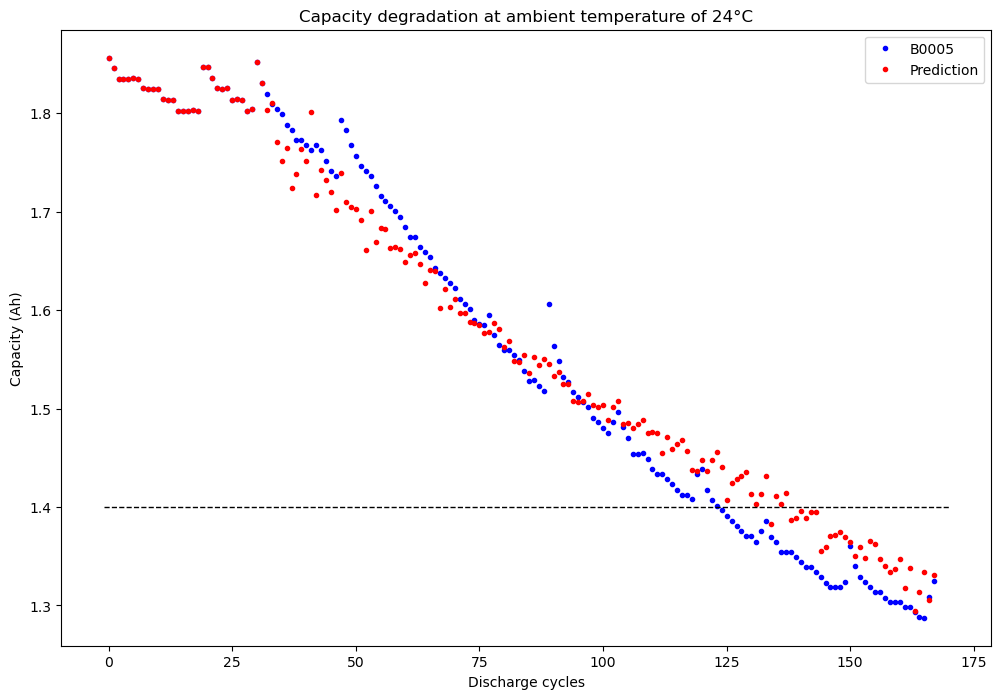

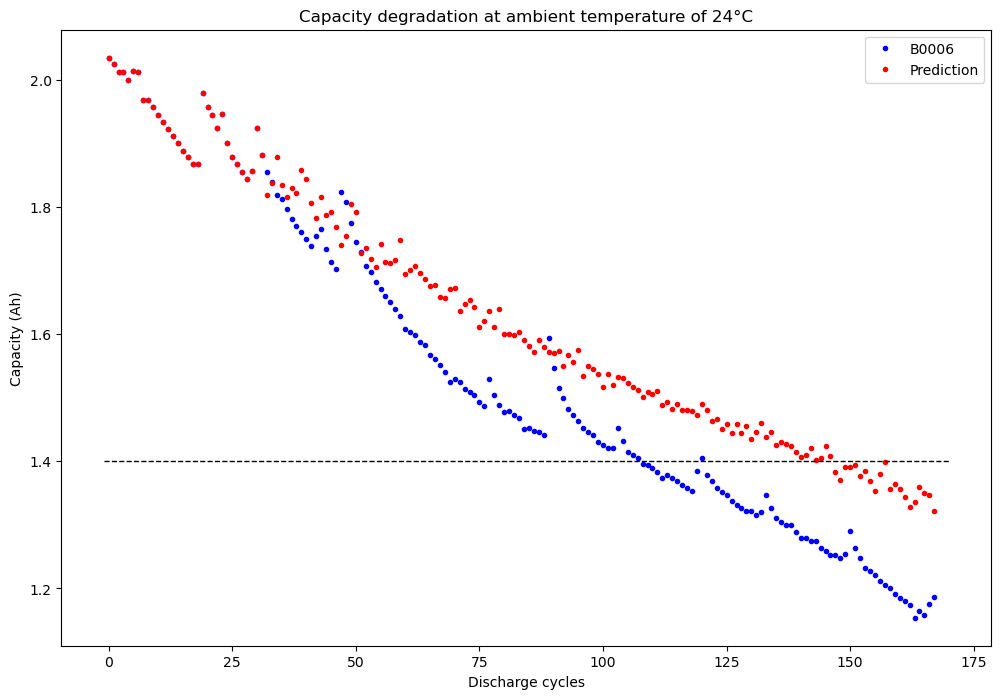

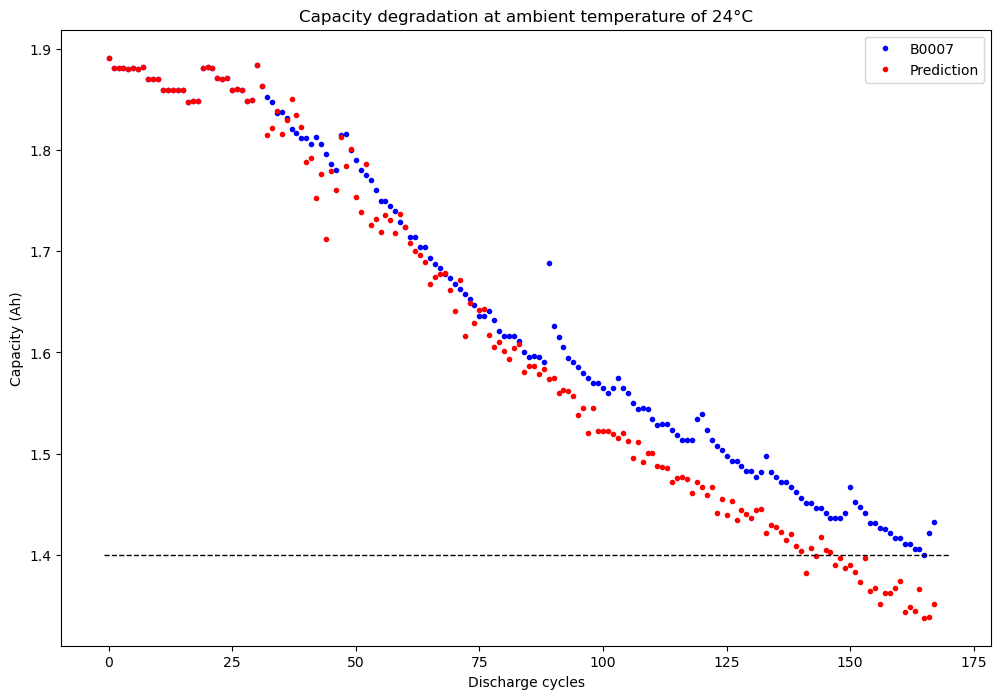

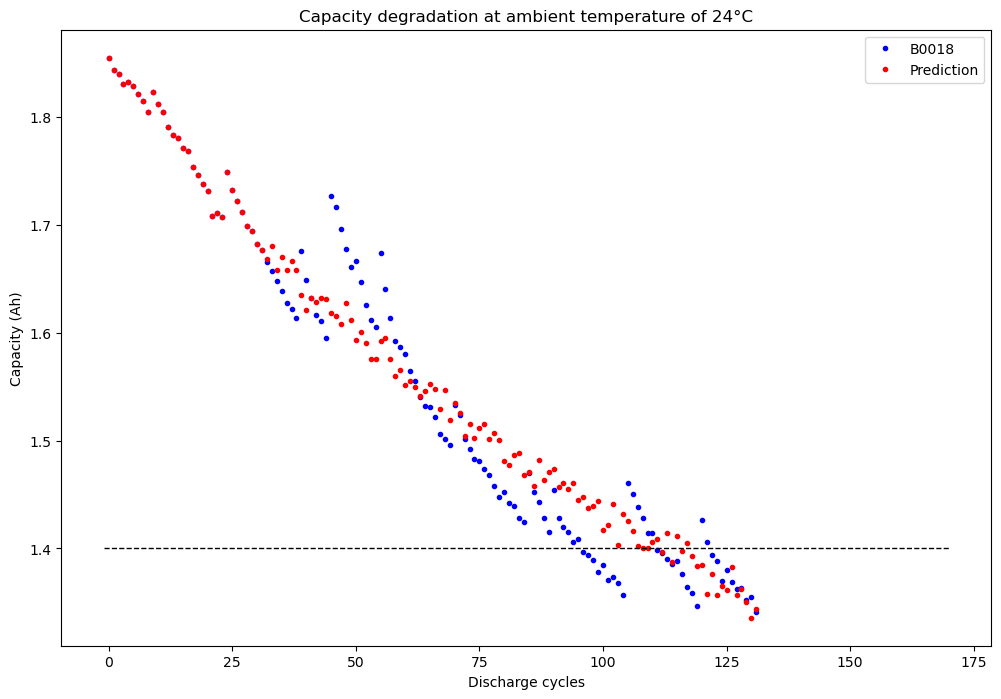

In [26]:
for name in data_dict.keys():
    train_x, train_y, train_data, test_data = get_train_test(data_dict, name, window_size)

    real = data_dict[name][1]
    prefix_x = data_dict[name][1][:window_size]
    decode_seq = model.decode(prefix_x,max_length=len(test_data))
    
    plot(name=name,
         real_data=real,
        pred_data=decode_seq)